In [1]:
import warnings
warnings.filterwarnings("ignore")

from functools import partial

import torch
import torchvision.transforms.functional as TF
from transformers import AutoModelForCausalLM, AutoTokenizer
import diffusers

from src.llm_objects import spot_objects
from src.diffusion_models import SDXLEditingPipeline
from src.editing import CustomAttentionProcessor

device = torch.device("cuda:1")
device1 = torch.device("cuda:2")

In [2]:
# Model and tokenizer names
model_name = "google/gemma-7b-it"

# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name).eval().to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


# Extract objects from the prompt using LLMs

In [3]:
model_params = {
    "max_new_tokens": 200,
}
prompts = [
    "a realistic cartoon-style image with a princess and four dwarfs",
    "a vivid photo with a woman on the right and a clown on the left walking in a dirty alley",
    "a monkey sitting above a green motorcycle on the left and another raccoon sitting above a blue motorcycle on the right",
    "a photo of a giant macaron and a croissant splashing in the Seine with the Eiffel Tower in the background",
    "a DSLR photo of a meatball and a donut falling from the clouds onto a neighborhood",
]
results = []
for prompt in prompts:
    result = spot_objects(tokenizer, model, prompt, device, **model_params)
    results.append(result)

In [4]:
idx = 2
results[idx]

{'objects': [('monkey', [None]),
  ('motorcycle', ['green']),
  ('raccoon', [None]),
  ('motorcycle', ['blue'])],
 'bg_prompt': 'Unknown',
 'neg_prompt': ''}

# Image generation

In [5]:
base = SDXLEditingPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  use_safetensors=True, torch_dtype=torch.float16, variant="fp16", use_onnx=False
)
base.to(device1)
use_ddpm = True
if use_ddpm:
  print('Using DDPM as scheduler.')
  base.scheduler = diffusers.DDPMScheduler.from_config(base.scheduler.config)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Using DDPM as scheduler.


In [6]:

_SG_RES = 64
save_aux=True 

attn_greenlist = []
self_attn_greenlist = []
for i in range(0, len(base.unet.up_blocks)-2):
   for j in range(len(base.unet.up_blocks[i].attentions)):
      base_name = f"up_blocks.{i}.attentions.{j}.transformer_blocks"
      for name, module in base.unet.up_blocks[i].attentions[j].transformer_blocks.named_children():
        for name_child, module_child in module.named_children():
          if name_child == "attn2":
              attn_greenlist.append(base_name+f".{name}.{name_child}")
          elif name_child == "attn1":
              self_attn_greenlist.append(base_name+f".{name}.{name_child}")
for name, block in base.unet.named_modules():
    if isinstance(block, (diffusers.models.unet_2d_blocks.CrossAttnDownBlock2D, diffusers.models.unet_2d_blocks.CrossAttnUpBlock2D, diffusers.models.unet_2d_blocks.UNetMidBlock2DCrossAttn)):
        for attn_name, attn in block.named_modules():
            full_name = name+'.'+attn_name
            if 'attn2' not in attn_name or (attn_greenlist and full_name not in attn_greenlist): 
                continue
            if isinstance(attn, diffusers.models.attention_processor.Attention):
                if isinstance(attn.processor, diffusers.models.attention_processor.AttnProcessor2_0):
                    attn.processor = CustomAttentionProcessor(_SG_RES, save_aux)
                else:
                    raise NotImplementedError("Self-guidance is not implemented for this attention processor")
def resave_aux_key(module, *args, old_key="attn", new_key="last_attn"):
    module._aux[new_key] = module._aux[old_key]

def resize(x):
    return TF.resize(x, _SG_RES, antialias=True)

def stash_to_aux(module, args, kwargs, output, mode, key="last_feats", args_idx=None, kwargs_key=None, fn_to_run=None):
    to_save = None
    if mode == "args":
        to_save = input
        if args_idx is not None:
            to_save = args[args_idx]
    elif mode == "kwargs":
        assert kwargs_key is not None
        to_save = kwargs[kwargs_key]
    elif mode == "output":
        to_save = output
    if fn_to_run is not None:
        to_save = fn_to_run(to_save)
    try:
        global save_aux
        if not save_aux:
            len_ = len(module._aux[key])
            del module._aux[key]
            module._aux[key] = [None]*len_ + [to_save]
        else:
            module._aux[key][-1] = module._aux[key][-1].cpu()
            module._aux[key].append(to_save)
    except:
      try:
          del module._aux[key]
      except:
          pass
      module._aux = {key: [to_save]}

handle1 = base.unet.up_blocks[2].register_forward_hook(partial(stash_to_aux,mode="output"), with_kwargs=True)
handle2 = base.unet.up_blocks[0].attentions[1].transformer_blocks[3].attn2.register_forward_hook(resave_aux_key)

In [7]:
SEED = 1
generator = torch.Generator(device=device1).manual_seed(SEED)
N_IMG=1
save_aux=True

In [8]:
out = base(prompt=[prompts[idx]]*N_IMG, num_inference_steps=300, generator=generator, save_aux=save_aux, latents=None)
if save_aux: 
    aux = base.get_sg_aux()

100%|██████████| 300/300 [00:51<00:00,  5.83it/s]


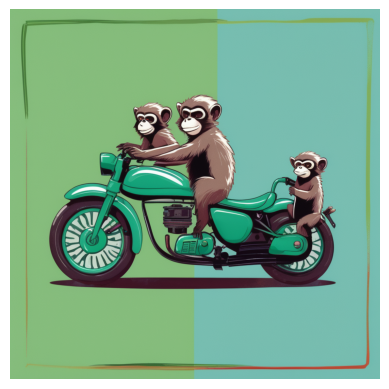

In [9]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(out.images[0])